# Hand written signature Verification and accuracy computation

# Aim Of Project

The complete aim of this project is to devlope a complete web application which can calculate the Accuracy percentage between Original Signature And User scanned signature.

# Line diagram of project

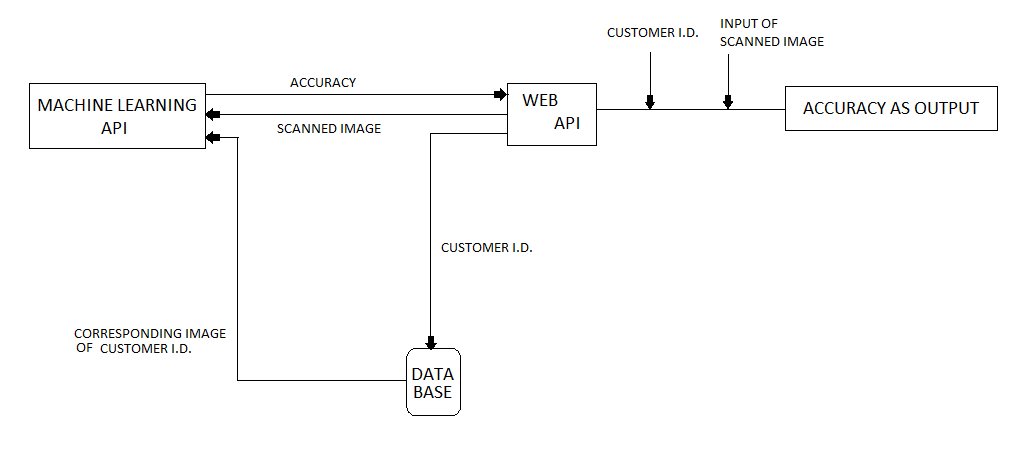

In [1]:
from IPython.display import Image
Image(filename='diag..png')



The complete project work on machine learning model to recognise the signature accuracy.
* The user has to register their account with original customer id and original signature at first time.
* Then these detail will be stored into our database.
* Again when user will upload their signature for verivication the signature will be verified by our machine learning API
* As result this image will be displayed with their accuracy
* we also verify fingerprint verification accuracy.

# This project is under devlopment phase.

In [2]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import os


In [5]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras import backend as K
#from SignatureDataGenerator import SignatureDataGenerator
import getpass as gp
import sys
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import random
random.seed(1337)

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Create a session for running Ops on the Graph.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

In [5]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [6]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    
    return (shape1[0], 1)

In [7]:
import tensorflow as tf

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [8]:
tot_writers=3000
num_train_writers=1000
num_valid_writers=400
num_test_writers=200
nsamples=400
batch_sz=10
img_height=100
img_width=100
featurewise_center=False,
featurewise_std_normalization=False,
zca_whitening=False

In [9]:
def standardize(x):
        
        if featurewise_center:
            if mean is not None:
                x -= mean
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_center`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if featurewise_std_normalization:
            if std is not None:
                x /= (self.std + 1e-7)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if zca_whitening:
            if principal_components is not None:
                flatx = np.reshape(x, (x.size))
                whitex = np.dot(flatx, principal_components)
                x = np.reshape(whitex, (x.shape[0], x.shape[1], x.shape[2]))
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        return x

In [10]:
def create_base_network_signet(input_shape):
    
    seq = Sequential()
    seq.add(Convolution2D(96, 11, 11, activation='relu', name='conv1_1', subsample=(4, 4), input_shape= input_shape, 
                        init='glorot_uniform', dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), dim_ordering='tf'))
    
    seq.add(Convolution2D(256, 5, 5, activation='relu', name='conv2_1', subsample=(1, 1), init='glorot_uniform',  dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Convolution2D(384, 3, 3, activation='relu', name='conv3_1', subsample=(1, 1), init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2', subsample=(1, 1), init='glorot_uniform', dim_ordering='tf'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
#    model.add(SpatialPyramidPooling([1, 2, 4]))
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform')) # softmax changed to relu
    
    return seq

In [11]:
img_height = 100
img_width = 100

input_shape=(img_height, img_width, 1)

# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)
#print(eucl_dist_output_shape.shape)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (11, 11), activation="relu", name="conv1_1", input_shape=(100, 100,..., strides=(4, 4), data_format="channels_last", kernel_initializer="glorot_uniform")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((2, 2), data_format="channels_last")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), activation="relu", name="conv2_1", strides=(1, 1), data_format="channels_last", kernel_initializer="glorot_uniform")`
  # Remove the CWD from sys.path while we load stuff.
/usr/

In [12]:
print(base_network.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 23, 23, 96)        11712     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 96)        92        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 15, 15, 96)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 11, 11, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 256)       44        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 256)         0         
__________

In [13]:
# compile model
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
adadelta = Adadelta()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=['accuracy'])

In [14]:
#plot(model, show_shapes=True)

In [15]:
fname = os.path.join('./log_dir/' , 'weights_sign'+'.hdf5')
checkpointer = ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)

In [16]:
import pandas as pd

In [17]:
df=pd.read_csv("dataset.csv")

In [18]:
from sklearn.utils import shuffle
df = shuffle(df)
df

,org_img,forg_img,label
732,signatures/full_forg/48/original_48_20.png,signatures/full_org/48/forgeries_48_7.png,0
1484,signatures/full_forg/1/original_1_4.png,signatures/full_forg/1/original_1_2.png,1
893,signatures/full_forg/53/original_53_9.png,signatures/full_org/53/forgeries_53_14.png,0
1214,signatures/full_forg/15/original_15_22.png,signatures/full_org/15/forgeries_15_4.png,0
1952,signatures/full_forg/19/original_19_4.png,signatures/full_forg/19/original_19_20.png,1
302,signatures/full_forg/23/original_23_22.png,signatures/full_org/23/forgeries_23_15.png,0
1454,signatures/full_forg/49/original_49_22.png,signatures/full_forg/49/original_49_8.png,1
1743,signatures/full_forg/20/original_20_5.png,signatures/full_forg/20/original_20_22.png,1
2512,signatures/full_forg/35/original_35_22.png,signatures/full_forg/35/original_35_16.png,1
201,signatures/full_forg/44/original_44_22.png,signatures/full_org/44/forgeries_44_4.png,0


In [19]:
def arrange_lines(lines, nsamples, size):
        
        idx_lines = []
    
        lp = []
        lin = []
    
        for iline, line in enumerate(lines):
            
            file1, file2, label = line.split(' ')
            
            label = int(label)
            
            lp += [label]        
            lin += [iline]
            
            if(len(lp) != 0 and len(lp) % size == 0):                
                            
                idx1 = [i for i, x in enumerate(lp) if x == 1]
                idx2 = [i for i, x in enumerate(lp) if x == 0]
                
                idx1 = np.random.choice(idx1, nsamples)
                idx2 = np.random.choice(idx2, nsamples)
                
                idx = [None]*(len(idx1)+len(idx2))
                
                idx[::2] = idx1
                idx[1::2] = idx2
                
                del idx1
                del idx2
                
                idx_lines += [lin[i] for i in idx]
                
                lp = []
                lin = []            
            
        lines = [lines[i] for i in idx_lines]

        just_1 = lines[0:][::2]
        just_0 = lines[1:][::2]
        random.shuffle(just_1)
        random.shuffle(just_0)
        lines= [item for sublist in zip(just_1,just_0) for item in sublist]
        
        return lines

In [20]:
cur_train_index = 0
cur_valid_index = 0
cur_test_index = 0
idx_writers = list(range(tot_writers))
size = 996 

idx_train_writers = sorted(np.random.choice(idx_writers, num_train_writers, replace=False))
idx_valid_writers = sorted(np.random.choice([x for x in idx_writers if x not in idx_train_writers], num_valid_writers, replace=False))
idx_test_writers = sorted(np.random.choice([x for x in idx_writers if x not in idx_train_writers and x not in idx_valid_writers], num_test_writers, replace=False))


'''train_lines = [lines[i] for i in idx_train_lines]
valid_lines = [lines[i] for i in idx_valid_lines]
test_lines = [lines[i] for i in idx_test_lines]

idx_train_lines = []
for iw in idx_train_writers:
    idx_train_lines += list(range(iw * size, (iw + 1) * size))

idx_valid_lines = []
for iw in idx_valid_writers:
    idx_valid_lines += list(range(iw * size, (iw + 1) * size))

idx_test_lines = []
for iw in idx_test_writers:
    idx_test_lines += list(range(iw * size, (iw + 1) * size))

train_lines = arrange_lines(train_lines, nsamples, size)
        # self.train_lines = self.arrange_lines(train_lines, nsamples, 552) 
        # for valid writers        
valid_lines = arrange_lines(valid_lines, nsamples, size)
        # for test writers        
        # self.test_lines = self.arrange_lines(test_lines, nsamples, size)
test_lines = arrange_lines(test_lines, nsamples, 552)'''


'train_lines = [lines[i] for i in idx_train_lines]\nvalid_lines = [lines[i] for i in idx_valid_lines]\ntest_lines = [lines[i] for i in idx_test_lines]\n\nidx_train_lines = []\nfor iw in idx_train_writers:\n    idx_train_lines += list(range(iw * size, (iw + 1) * size))\n\nidx_valid_lines = []\nfor iw in idx_valid_writers:\n    idx_valid_lines += list(range(iw * size, (iw + 1) * size))\n\nidx_test_lines = []\nfor iw in idx_test_writers:\n    idx_test_lines += list(range(iw * size, (iw + 1) * size))\n\ntrain_lines = arrange_lines(train_lines, nsamples, size)\n        # self.train_lines = self.arrange_lines(train_lines, nsamples, 552) \n        # for valid writers        \nvalid_lines = arrange_lines(valid_lines, nsamples, size)\n        # for test writers        \n        # self.test_lines = self.arrange_lines(test_lines, nsamples, size)\ntest_lines = arrange_lines(test_lines, nsamples, 552)'

In [21]:
from keras.preprocessing import image
from PIL import Image
import tqdm
import cv2
def next_train():
    samples_per_train = 2*nsamples*num_train_writers
    cur_train_index = 0
    while True:
        height,width=100,100

        images = []
        images2=[]
        label_pairs = []
        image_pairs=[]
        if cur_train_index == samples_per_train:
                cur_train_index = 0
                
        cur_train_index = cur_train_index + batch_sz

        if cur_train_index > samples_per_train:
            cur_train_index = samples_per_train

            # print 'Cur Index', self.cur_train_index,'\n'
            # print 'End Index', cur_train_index, '\n'
        idx = list(range(cur_train_index, cur_train_index))
        label = df["label"][0:1200]
        for i in range(1200):#(len(df["org_img"])):#tqdm.tqdm(total=len(df["org_img"])):
                file1=df["org_img"][i]
                file2=df["forg_img"][i]
                #label = df["label"][i]
                #print(file1)

                img1 = image.load_img("./"+file1,grayscale = True,
                    target_size=(height, width))

                img1 = image.img_to_array(img1)#, dim_ordering='tf')
                #images.append(img1)
                #img1 = standardize(img1)

                img2 = image.load_img("./"+file2,grayscale = True,
                    target_size=(height, width))

                img2 = image.img_to_array(img2)#, dim_ordering='tf')
                #images2.append(img2)
                #img2 = standardize(img2)
                #label_pairs.append(label)
                image_pairs += [[img1, img2]]
                #print("label"+ label.shape)
                #label_pairs += [int(label)]
                #label_pairs.append(label)

        cur_train_index = cur_train_index
        images = [np.array(image_pairs)[:,0], np.array(image_pairs)[:,1]]
        labels = np.array(label)
        #print(labels.shape)
        yield(images,labels)
    #return images,images2

In [22]:
def next_val():
    samples_per_train = 2*nsamples*num_train_writers
    cur_train_index = 0
    while True:
        height,width=100,100

        images = []
        images2=[]
        label_pairs = []
        image_pairs=[]
        if cur_train_index == samples_per_train:
                cur_train_index = 0
                
        cur_train_index = cur_train_index + batch_sz

        if cur_train_index > samples_per_train:
            cur_train_index = samples_per_train

            # print 'Cur Index', self.cur_train_index,'\n'
            # print 'End Index', cur_train_index, '\n'
        idx = list(range(cur_train_index, cur_train_index))
        label = df["label"][1201:1700]
        for i in range(len(df["org_img"][1201:1700])):#dm(total=len(df["org_img"])):
                file1=df["org_img"][i]
                file2=df["forg_img"][i]
                #label = df["label"][i]
                #print(file1)

                img1 = image.load_img("./"+file1,grayscale = True,
                    target_size=(height, width))

                img1 = image.img_to_array(img1)#, dim_ordering='tf')
                #images.append(img1)
                #img1 = standardize(img1)

                img2 = image.load_img("./"+file2,grayscale = True,
                    target_size=(height, width))

                img2 = image.img_to_array(img2)#, dim_ordering='tf')
                #images2.append(img2)
                #img2 = standardize(img2)
                #label_pairs.append(label)
                image_pairs += [[img1, img2]]
                #print("label"+ label.shape)
                #label_pairs += [int(label)]
                #label_pairs.append(label)

        cur_train_index = cur_train_index
        images = [np.array(image_pairs)[:,0], np.array(image_pairs)[:,1]]
        labels = np.array(label)
        #print(labels.shape)
        yield(images,labels)
    #return images,images2

In [23]:
import matplotlib.pyplot as plt
def pre_process(img):
    plt.imshow(img)
    #hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #hue ,saturation ,value = cv2.split(hsv)
    #retval, thresholded = cv2.threshold(saturation, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #medianFiltered = cv2.medianBlur(thresholded,5)
    #gray_image = cv2.cvtColor(medianFiltered, cv2.COLOR_HSV2GRAY)
    #resized_image = cv2.resize(img, (115, 220))
    img=img.resize((100,100),Image.ANTIALIAS)
    return img



In [24]:
m=next_train()

In [25]:
#m=np.reshape(m,(220,155))
#m=np.array(m)
#m1=np.reshape(m1,(220,155))


In [26]:
print(m)

<generator object next_train at 0x7fecb816ee60>


In [27]:
l=df["label"][:10]
#print(l)
l=pd.get_dummies(l).values
#print(l.shape)

In [28]:
print(l)

[[1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]]


In [ ]:
history=model.fit_generator(generator=m,steps_per_epoch=10,validation_data=next_val(),epochs=50,validation_steps=5,callbacks=[checkpointer])

Epoch 1/500


In [ ]:
model.load_weights(fname)

In [8]:
import numpy as np
image_pairs=[]
image_pairs += [[rawImage, rawImage1]]
images = [np.array(image_pairs)[:,0], np.array(image_pairs)[:,1]]

In [9]:
import matplotlib.pyplot as plt
#original image
rawImage = image.load_img('./signatures/full_forg/44/original_44_21.png',grayscale = True,
                    target_size=(100,100))
rawImage=image.img_to_array(rawImage)

#forged image

rawImage1 = image.load_img('./signatures/full_forg/44/original_44_22.png',grayscale = True,
                    target_size=(100,100))
rawImage1=image.img_to_array(rawImage1)

In [12]:
print(image_pairs)


[[array([[[238.],
        [240.],
        [237.],
        ...,
        [243.],
        [238.],
        [240.]],

       [[239.],
        [237.],
        [239.],
        ...,
        [239.],
        [242.],
        [244.]],

       [[239.],
        [243.],
        [241.],
        ...,
        [236.],
        [240.],
        [241.]],

       ...,

       [[237.],
        [239.],
        [237.],
        ...,
        [235.],
        [241.],
        [246.]],

       [[228.],
        [240.],
        [236.],
        ...,
        [241.],
        [242.],
        [238.]],

       [[235.],
        [239.],
        [240.],
        ...,
        [229.],
        [241.],
        [243.]]], dtype=float32), array([[[241.],
        [247.],
        [237.],
        ...,
        [245.],
        [238.],
        [242.]],

       [[239.],
        [240.],
        [243.],
        ...,
        [244.],
        [237.],
        [245.]],

       [[238.],
        [241.],
        [234.],
        ...,
        [245.],
    

In [ ]:
p=model.predict(images)

In [ ]:
print("Accuracy between original and sacnned images is \n %0.2f" % (p,))

In [ ]:
def compute_acuray_roc(predictions,labels):
    dmax=np.max(predictions)
    dmin=np.min(predictions)
    nsame=np.sum(labels==1)
    ndiff=np.sum(labels==0)
    step=0.01
    max_acc=0
    for d in np.arange(dmin,dmax+step,step):
        idx1=predictions.ravel() <= d
        idx2=predictions.ravel() > d
        tpr=float(np.sum(labels[idx1] == 1)) / nsame
        tnr=float(np.sum(labels[idx2] == 0)) / ndiff
        acc=0.5*(tpr+tnr)
        if (acc>max_acc):
            max_acc=acc
    return max_acc

In [ ]:
#te_acc = compute_acuray_roc()